# What
Our code is a mess. This is just to not have to run everything all the time. Allows us to focus on the data we have instead of trying to get even more messy data.

This should be used as a default and copies should be done to build on top. The idea of this is that it's a basic AF readers so that actual analysis can be done.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statistics
import math
import plotly.express as px

# networkx
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# For semantic similarity
from urllib.parse import unquote
from transformers import BertTokenizer
from transformers import BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Python functions in .py file to read data
import data_readers

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings('ignore', category=TqdmWarning)

# Our custom plotting functions
import plot_functions

In [2]:
# The links and edges
wikispeedia = data_readers.read_wikispeedia_graph()

# The finished paths
finished_paths = data_readers.read_finished_paths()

# The unfinished paths
unfinished_paths = data_readers.read_unfinished_paths()

# DF of all articles and their categories
categories = data_readers.read_categories()

# Searching for the string of a given article. It has to be formatted like the article name
# Which shouldn't be a problem, as we'll probably usually retrieve them internally
obi_wan_text = data_readers.plaintext_article_finder('Obi-Wan_Kenobi')

source_target_info = data_readers.source_target_paths_information()

In [3]:
# This is a last step, of making these three datasets have consistent column names and order
# as well as guaranteeing that the index order is conistent with both elements
# Even though the boolean column is weird, it's a boolean so that's all good

# FUCK IT. We don't touch the decoded version, that's too painful!

col_names = ['source', 'target', 'reached', 'length', 'visited']

import ast

carlos_df = pd.read_csv('machine_outputs/data_carlos.csv')
carlos_df.columns = col_names

carlos_df['visited'] = carlos_df['visited'].str.strip('\\').str.strip('{}')
carlos_df['visited'] = carlos_df['visited'].apply(lambda x: ast.literal_eval(x))

semantic_rank_df = pd.read_csv('machine_outputs/carolOutput.csv')
semantic_rank_df.columns = col_names

semantic_rank_df['visited'] = semantic_rank_df['visited'].str.strip('\\').str.strip('{}')
semantic_rank_df['visited'] = semantic_rank_df['visited'].apply(lambda x: ast.literal_eval(x))

landmark_df = pd.read_csv('machine_outputs/landmark_method_results.csv')

# Landmark_df is the only one with substantive change
landmark_df.drop('Unnamed: 0', axis=1, inplace=True)
landmark_df['reached'] = True
landmark_df.columns = ['source', 'target', 'length', 'visited', 'reached']
landmark_df = landmark_df[col_names]
# Due to the way length was counted here, I need to update to increase by one
landmark_df['length'] = landmark_df['length'] + 1

landmark_df['visited'] = landmark_df['visited'].str.strip('\\').str.strip('{}')
landmark_df['visited'] = landmark_df['visited'].apply(lambda x: ast.literal_eval(x))
landmark_df = landmark_df.sort_values('source')

In [4]:
finished_paths = finished_paths[['first_article', 'last_article', 'path_length', 'path']]
finished_paths = finished_paths.rename(columns={'first_article':'source', 'last_article':'target', 'path_length':'length','path':'visted'})

Modify given datasets

In [5]:
unfinished_paths['source'] = unfinished_paths['path'].str.split(';').apply(lambda x: x[0])
unfinished_paths = unfinished_paths[['source', 'target', 'path', 'type']]


In [6]:
def add_category_of_target_article(df_to_add_category_to) -> pd.DataFrame:
    categories[categories['article'].duplicated()]
    categories['article'] = categories['article'].drop_duplicates()
    sub_categories = categories['categories'].str[8:].str.split('.')
    category_depth_1 = sub_categories.apply(lambda x: x[0])
    categories['category'] = category_depth_1

    new_df = pd.merge(df_to_add_category_to, categories, left_on = 'target', right_on= 'article', how = 'left')
    new_df = new_df.drop(columns = ['article', 'categories'])
    return new_df

finished_paths = add_category_of_target_article(finished_paths)
unfinished_paths = add_category_of_target_article(unfinished_paths)

landmark_df = add_category_of_target_article(landmark_df)
semantic_rank_df = add_category_of_target_article(semantic_rank_df)
carlos_df = add_category_of_target_article(carlos_df)

What are the most common finished, and unfinished paths?

In [7]:
def normalize_category_frequency_by_num_articles_they_have(paths_df, category_df = categories) -> pd.DataFrame:
    # Returns frequency of categories of target articles in finished/unfinished paths
    category_counts = paths_df['category'].value_counts()
    num_articles_per_category = categories.groupby('category')['article'].count()
    normalized_category_counts = category_counts / num_articles_per_category
    normalized_category_counts = normalized_category_counts.sort_values(ascending=False)
    return normalized_category_counts

normalized_category_counts_finished = normalize_category_frequency_by_num_articles_they_have(finished_paths)
normalized_category_counts_unfinished = normalize_category_frequency_by_num_articles_they_have(unfinished_paths)

In [8]:
plot_functions.barplot_solo(normalized_category_counts_finished, file_name= 'normalized_category_counts_finished', title = "Normalized Frequency of Categories of Target Articles in Finished Paths", color = 'red')
plot_functions.barplot_solo(normalized_category_counts_unfinished, file_name= 'normalized_category_counts_unfinished', title = "Normalized Frequency of Categories of Target Articles in Unfinished Paths", color = 'blue')


When are human paths shorter than the machine paths?

In [9]:
def combine_human_and_machine(df_human, df_machine) -> pd.DataFrame:
    df = pd.merge(df_human, df_machine, how = 'inner', left_on= ['first_article', 'last_article'], right_on = ['Source', 'Target'])
    df.rename(columns= {'path_length': 'man_len', 'len_shortest_path': 'machine_len'}, inplace=True)
    return df

In [10]:
a = finished_paths.groupby('category')['length'].mean()
b = landmark_df.groupby('category')['length'].mean()
c = semantic_rank_df.groupby('category')['length'].mean()
d = carlos_df.groupby('category')['length'].mean()

avg_lengths_df = pd.DataFrame((a,b,c, d)).T
avg_lengths_df.columns = ['human', 'landmark', 'semantic_rank', 'carlos']
avg_lengths_df = avg_lengths_df.sort_values('human')

plot_functions.barplot_groups(avg_lengths_df, file_name= 'avg_lengths', title='Average Finished Path Length by Category of Machine vs Man', barmode='group')

In [11]:
source_target_info.columns

Index(['first_article', 'last_article', 'count', 'mean_length', 'std_length',
       'mean_rating', 'std_rating', 'mean_durationInSec', 'std_durationInSec'],
      dtype='object')

## Analyzing the frequency of lengths

Text(0.5, 1.0, 'Histogram of lengths for Landmark Approach')

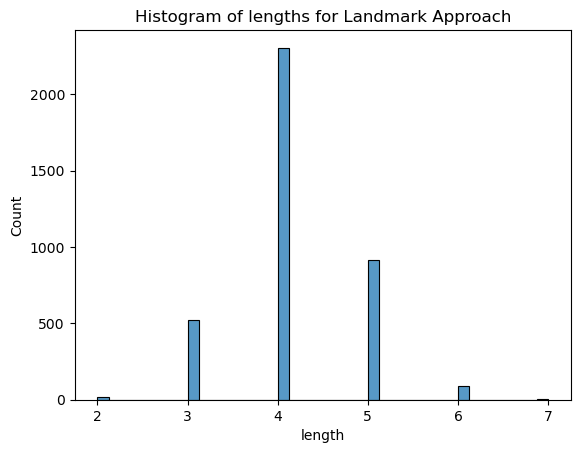

In [12]:
sns.histplot(data=landmark_df, x='length')
plt.title('Histogram of lengths for Landmark Approach')

Text(0.5, 1.0, 'Histogram of lengths for SemanticRank Approach')

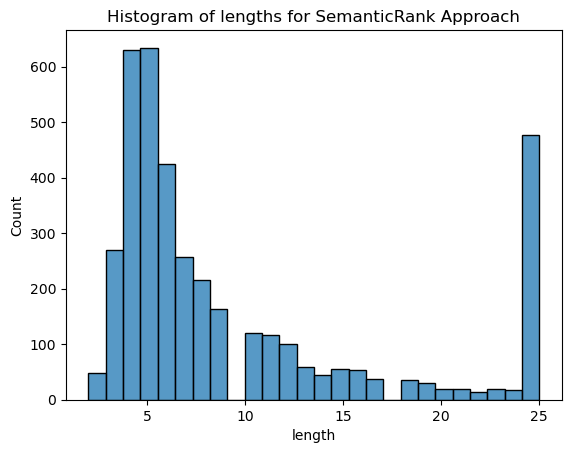

In [13]:
sns.histplot(data=semantic_rank_df, x='length')
plt.title('Histogram of lengths for SemanticRank Approach')

In [14]:
finished_paths.columns

Index(['source', 'target', 'length', 'visted', 'category'], dtype='object')

Text(0.5, 1.0, 'Histogram of lengths for human data')

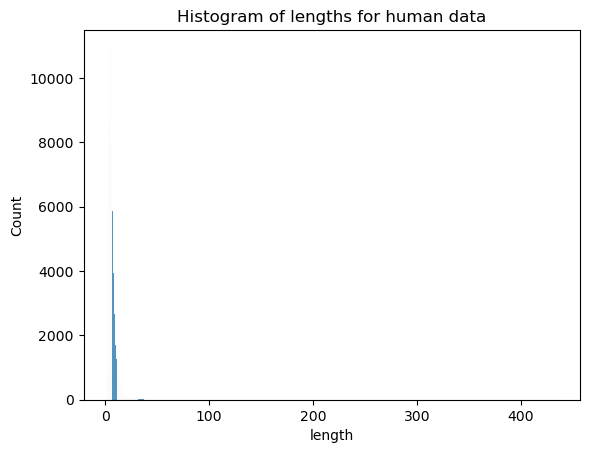

In [15]:
sns.histplot(data=finished_paths, x='length')
plt.title('Histogram of lengths for human data')

In [16]:
finished_paths.sort_values(by='length', ascending=False)

,source,target,length,visted,category
8046,United_States,English_language,435,United_States;Washington%2C_D.C.;Government;Co...,Language_and_literature
19961,Napoleon_I_of_France,Recycling,119,Napoleon_I_of_France;United_Kingdom;Great_Brit...,Citizenship
6945,Police_state,African_slave_trade,104,Police_state;Police;United_States;Washington%2...,History
27136,Lake_Toba,Looney_Tunes,99,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,Everyday_life
22845,Britney_Spears,Extraterrestrial_life,96,Britney_Spears;Las_Vegas%2C_Nevada;<;Las_Vegas...,Science
...,...,...,...,...,...
23347,Apple,Apple,1,Apple,Everyday_life
50466,William_and_Mary,William_and_Mary,1,William_and_Mary,History
33832,Abel_Tasman,Abel_Tasman,1,Abel_Tasman,People
9872,Coal,Coal,1,Coal,Citizenship


In [17]:
(finished_paths['length'] >= 25).sum()

432

Text(0.5, 1.0, 'Histogram of lengths for human data')

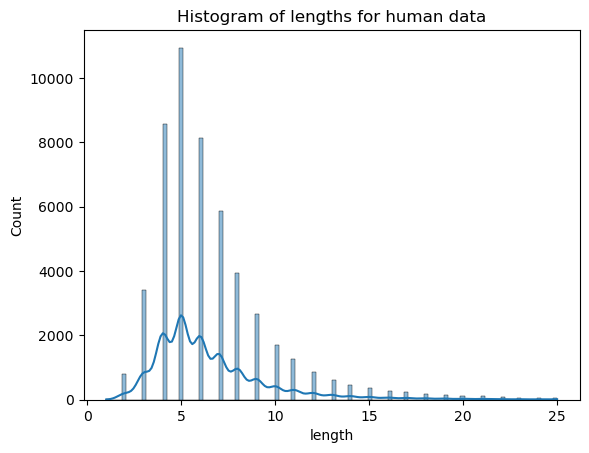

In [18]:
trimmed_finished = finished_paths[finished_paths['length'] <= 25]

sns.histplot(data=trimmed_finished, x='length', kde=True)
plt.title('Histogram of lengths for human data')

In [22]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(wikispeedia))

# Now, just go through the paths and store the values in a list...
# I'll assume everything is in landmark_df, just to make things easier
optimal_shortest_paths = []

# Takes about 30s to run
for index, row in landmark_df.iterrows():
    optimal_shortest_paths.append(shortest_paths[row['source']][row['target']])

In [23]:
landmark_df.head()

,source,target,reached,length,visited,category
0,10th_century,11th_century,True,4,"[10th_century, 11th_century, 20th_century, 11t...",History
1,11th_century,Taiwan,True,3,"[11th_century, 19th_century, Taiwan]",Geography
2,12th_century,Zimbabwe,True,4,"[12th_century, Croatia, List_of_countries_by_s...",Geography
3,12th_century,Guitar,True,4,"[12th_century, India, South_America, Guitar]",Music
4,14th_century,African_slave_trade,True,5,"[14th_century, China, United_States, History_o...",History


Text(0.5, 1.0, 'Histogram of lengths for optimal values')

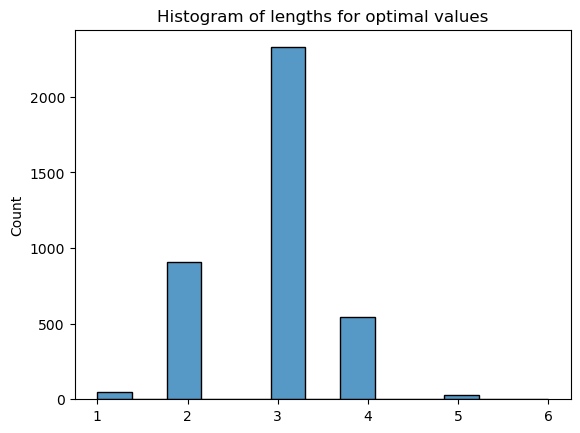

In [24]:
sns.histplot(data=optimal_shortest_paths)
plt.title('Histogram of lengths for optimal values')

## Trying to characterize paths

I wanna see if I can characterize the paths. This shit is painful, as we have to try and deal with the different elements. 

Most intuitive solution I could think of is getting the average embedding, do TSNE afterwards, and do a nice plot with color representing the lengths.

In [25]:
# Imports needed to get the embeddings
from sentence_transformers import SentenceTransformer
import torch
model = SentenceTransformer('all-MiniLM-L6-v2')

def decode_word(word):
    word = word.replace('_', ' ')
    return unquote(word)

# Function to get embeddings using sentence transformer
def get_embedding(text):
    return model.encode(decode_word(text), convert_to_tensor=True)

# Function to perform L2 normalization on the embeddings
def l2_normalize(tensor):
    return tensor / tensor.norm(p=2, dim=0, keepdim=True)

# Function to calculate semantic similarity between two pieces of text
def semantic_similarity(word1, word2):
    embedding1 = get_embedding(word1)
    embedding2 = get_embedding(word2)

    # L2 normalization of the embeddings (to make sure, although embedding should already be normalized)
    embedding1_normalized = l2_normalize(embedding1)
    embedding2_normalized = l2_normalize(embedding2)

    # Compute and return the similarity of normalized tensors
    return torch.dot(embedding1_normalized, embedding2_normalized).item()

def get_mean_embeddings(elem_list: list) -> torch.tensor:
    result = get_embedding(elem_list[0])

    for i in range(1, len(elem_list)-1):
        result += get_embedding(elem_list[i])
    return result/len(elem_list)

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_tsne_mean_embedding_of_path(input: pd.DataFrame) -> pd.DataFrame:
    mean_embedding = input['visited'].apply(get_mean_embeddings)
    
    temp = torch.zeros((input.shape[0], 384))
    for i in range(len(mean_embedding)-1):
        temp[i] = mean_embedding[i]

    tsne = TSNE()

    tsne_input = tsne.fit_transform(temp)
    
    # Need to expand the dimension of input length so the concatenation works out
    temp_test = np.concatenate([tsne_input, np.expand_dims(input['length'].values, 1)], axis=1)
    df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])
    
    return df

In [27]:
semantic_rank_tsne_df = get_tsne_mean_embedding_of_path(semantic_rank_df)
landmark_tsne_df = get_tsne_mean_embedding_of_path(landmark_df)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0.5, 1.0, 'Semantic Rank Mean Embedding TSNE and Length')

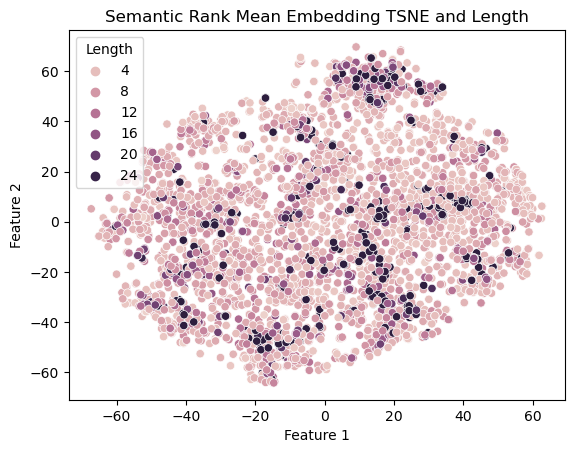

In [28]:
sns.scatterplot(data=semantic_rank_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Semantic Rank Mean Embedding TSNE and Length')

Text(0.5, 1.0, 'Landmark TSNE and Length')

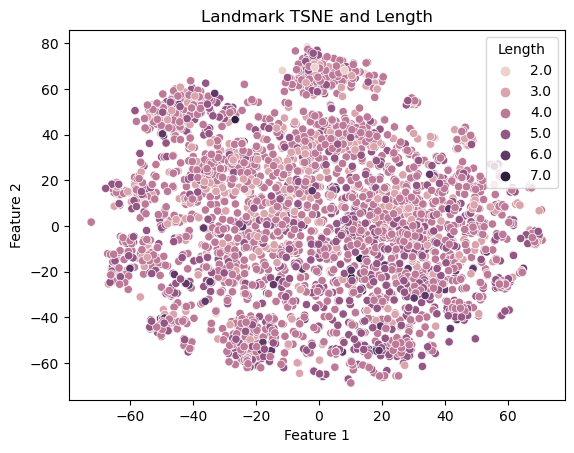

In [29]:
sns.scatterplot(data=landmark_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Landmark TSNE and Length')

In [30]:
# Now, just go through the paths and store the values in a list...
# I'll assume everything is in landmark_df, just to make things easier
shortest_paths_themselves = []

for index, row in landmark_df.iterrows():
    shortest_paths_themselves.append(nx.shortest_path(wikispeedia, row['source'], row['target']))

temp = torch.zeros((landmark_df.shape[0], 384))
for i in range(landmark_df.shape[0]-1):
    temp[i] = get_mean_embeddings(shortest_paths_themselves[i])

tsne = TSNE()
tsne_input = tsne.fit_transform(temp)

lengths_optimal = [len(item) for item in shortest_paths_themselves]

lengths_optimal = np.expand_dims(np.array(lengths_optimal), 1)

# Need to expand the dimension of input length so the concatenation works out
temp_test = np.concatenate([tsne_input, lengths_optimal], axis=1)
df = pd.DataFrame(temp_test, columns=['Feature 1', 'Feature 2', 'Length'])

Text(0.5, 1.0, 'Optimal TSNE and Length')

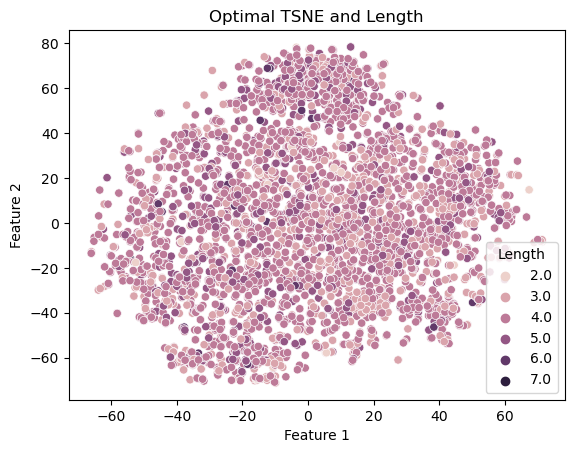

In [31]:
sns.scatterplot(data=df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Optimal TSNE and Length')

Text(0.5, 1.0, 'Semantic Rank Mean Embedding TSNE and Length')

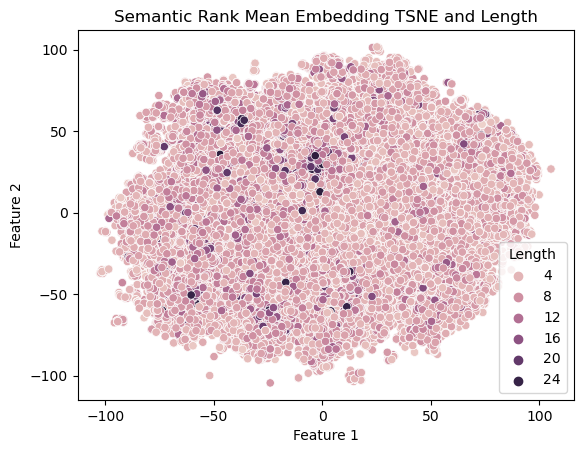

In [36]:
# This shit takes forever to run, no fucking surprise. If someone can do this for me
# I'd give them kisses and love
trimmed_finished = finished_paths.loc[finished_paths['length'] <= 25, :].reset_index(drop=True)

trimmed_finished.columns = ['source', 'target', 'length', 'visited', 'category']
trimmed_finished.loc[:, 'visited'] = trimmed_finished['visited'].str.split(';')

human_tsne_df = get_tsne_mean_embedding_of_path(trimmed_finished)

sns.scatterplot(data=human_tsne_df, x='Feature 1', y='Feature 2', hue='Length')
plt.title('Semantic Rank Mean Embedding TSNE and Length')

Can machine do some of the unfinished paths that man couldn’t?

We'll only focus on the ones that happened by restart, as those are the most relevant ones.

Additionally, because we only care about whether it's achievable or not, we will only focus on whether a path was found or not.


In [37]:
unique_unfinished_paths = unfinished_paths.groupby(['source','target']).size().reset_index().rename(columns={0:'count'})

import machine_searchers

landmark_method = machine_searchers.LandmarkSearch(wikispeedia)
semantic_rank_method = machine_searchers.AlgorithmCarol(wikispeedia)

In [38]:
# This shit takes forever to run, no fucking surprise. If someone can do this for me
# I'd give them kisses and love

landmark_res = []
semantic_rank_res = []

not_found_landmark = []
not_found_semantic_rank = []

for index, row in unique_unfinished_paths.iterrows():
    try:
        # If it's not a key, by default I'll assume it's false
        # So if this works it's just true
        _ = landmark_method.find_shortest_path(row['source'], row['target'])
        landmark_res.append(True)
    except:
        landmark_res.append(False)
        not_found_landmark.append((row['source'], row['target']))
        
    _, _, _, path_length, _ = semantic_rank_method.find_shortest_path(wikispeedia, row['source'], row['target'])
    
    if path_length >= 25:
        semantic_rank_res.append(True)
    else:
        semantic_rank_res.append(False)
        not_found_semantic_rank.append((row['source'], row['target']))


In [ ]:
print("Landmark has following percent found: ", np.array(landmark_res).sum()/len(landmark_res))
print("SemanticRank has following percent found: ", np.array(semantic_rank_res).sum()/len(semantic_rank_res))

In [ ]:
print("Unfound for Landmark are:")
print(not_found_landmark)

print('')
print("Unfound for Semantic rank are:")
print(not_found_semantic_rank)